# Predicting a Heart Attack

by Adhir Uchil

### Topic

This project seeks to use medical data from subjects to predict their risk of a heart attack. Since heart failure is a leading cause of death in the United States, significant research is dedicated to the task of predicting and minimizing heart risk. Statistical learning tools can be a play a big role in predicting how likely a given subject is from suffering heart failure in the near future.

Since we are ultimately estimating a categorical variable (labelled `output`) that encodes the risk of heart attack, this is a binary classification problem.

### Description of the Data

This data is a multi-table form sourced from a [Kaggle dataset by Rashik Rahman](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset). The data has 303 rows and 13 feature variables to predict the `output`. 

A description of the feature variables, [provided by Kaggle user Jay](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/234843) is as follows:

The numeric features are:
- `age`: age of the subject. Discrete - min 29, max 77
- `trtbps`: the resting blood pressure. Discrete - min 94, max 200
- `chol`: serum cholestrol in mg/dl. Discrete - min 126, max 564
- `thalachh`: maximum heart rate achieved. Discrete - min 71, max 202
- `oldpeak`: ST depression induced by exercise relative to rest. Continuous - min 0, max 6.2

The categorical features are:
- `sex`: 1 = male, 0 = female
- `cp`: chest pain type. 1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic
- `fbs`: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- `restecg`: resting electrocardiographic results (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)
- `exng`: exercise induced angina (1 = yes; 0 = no)
- `slp`: the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)
- `caa`: number of major vessels (0-3) colored by flourosopy
- `thall`:  2 = normal; 1 = fixed defect; 3 = reversible defect

And the output variable is:
- `output`: the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < diameter narrowing; Value 1 = > 50% diameter narrowing)

### Data Cleaning and EDA

Our first step will be to read the data from the "heart_new.csv" file and inspect some of the values.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics

In [5]:
df = pd.read_csv("heart_new.csv")

In [6]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


The first bit of cleaning is to convert the type of the categorical features. Here, we choose to leave the features with binary values (`sex`, `fbs`, `exng`) as is so that they can later show up in the correlation matrix. For features with more than two values, however, we will convert them to categorical columns since the values themselves have no inherent order.

In [7]:
df.cp = df.cp.astype('category')
df.restecg = df.restecg.astype('category')
df.slp = df.slp.astype('category')
df.caa = df.caa.astype('category')
df.thall = df.thall.astype('category')

In [8]:
df.dtypes

age            int64
sex            int64
cp          category
trtbps         int64
chol           int64
fbs            int64
restecg     category
thalachh       int64
exng           int64
oldpeak      float64
slp         category
caa         category
thall       category
output         int64
dtype: object

In [9]:
# Numeric columns
df.describe()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,131.623762,246.264026,0.148515,149.646865,0.326733,1.039604,0.455446
std,9.082101,0.466011,17.538143,51.830751,0.356198,22.905161,0.469794,1.161075,0.498835
min,29.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,120.000000,211.000000,0.000000,133.500000,0.000000,0.000000,0.000000
50%,55.000000,1.000000,130.000000,240.000000,0.000000,153.000000,0.000000,0.800000,0.000000
75%,61.000000,1.000000,140.000000,274.500000,0.000000,166.000000,1.000000,1.600000,1.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,1.000000


It is worth noting here that the mean of output (a column that can take on values of either 0 or 1) is 0.455. This indicates that the data is mostly balanced, with a relatively similar number of subjects who did and did not suffer from heart attack.

In [11]:
# Categorical columns
df.describe(include=['category'])

,cp,restecg,slp,caa,thall
count,303,303,303,303,303
unique,4,3,3,5,4
top,0,1,2,0,2
freq,143,152,142,175,166


Since the count for all the variables in the dataset returns 303, there are no NaN values to be dealt with. We can confirm this by checking the number of `isnull` values for every column in the dataframe.

In [12]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

The first EDA task is to use a correlation matrix to identify how the various feature variables and the output variable interact. This is important to confirm intuitions about the data and detect any unexpected relations between variables.

In [13]:
corr_matrix = df.corr()
corr_matrix

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,output
age,1.000000,-0.098447,0.279351,0.213678,0.121308,-0.398522,0.096801,0.210013,0.225439
sex,-0.098447,1.000000,-0.056769,-0.197912,0.045032,-0.044020,0.141664,0.096093,0.280937
trtbps,0.279351,-0.056769,1.000000,0.123174,0.177531,-0.046698,0.067616,0.193216,0.144931
chol,0.213678,-0.197912,0.123174,1.000000,0.013294,-0.009940,0.067023,0.053952,0.085239
fbs,0.121308,0.045032,0.177531,0.013294,1.000000,-0.008567,0.025665,0.005747,0.028046
thalachh,-0.398522,-0.044020,-0.046698,-0.009940,-0.008567,1.000000,-0.378812,-0.344187,-0.421741
exng,0.096801,0.141664,0.067616,0.067023,0.025665,-0.378812,1.000000,0.288223,0.436757
oldpeak,0.210013,0.096093,0.193216,0.053952,0.005747,-0.344187,0.288223,1.000000,0.430696
output,0.225439,0.280937,0.144931,0.085239,0.028046,-0.421741,0.436757,0.430696,1.000000


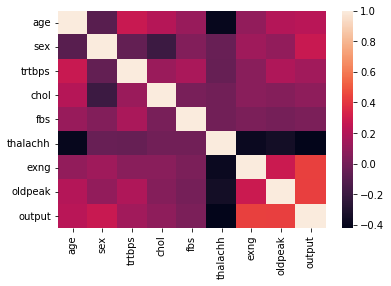

In [14]:
sn.heatmap(corr_matrix)
plt.show();

The correlation matrix confirmed a lot of things I knew from common knowledge, and also showed some unexpected results:

1) As expected there is a positive correlation between age and heart failure (0.2254). As one's age increases one is more prone to heart failure.

2) There is a similar correlation between sex and heart failure, indicating that males are more likely to suffer from heart failure than females.

3) The positive correlation between cholesterol and heart failure is surprisingly weak (0.085239). This interesting to note when cholesterol is normally considered one of the leading causes of heart attacks. 

Next, we will use boxplots to plot the numeric features (`age`, `trtbps`, `chol`, `thalachh`, `oldpeak`) to visualize the distribution and make note of outliers.

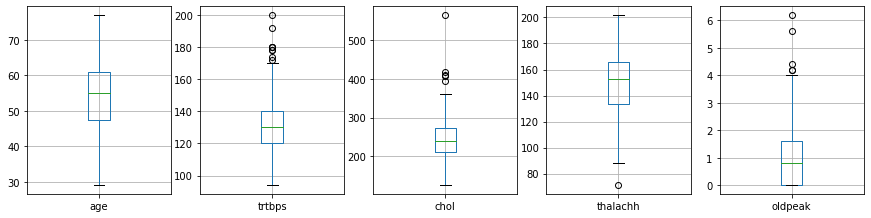

In [15]:
cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
fig = plt.figure(figsize=(15, 20))
for i in range(len(cols)):
    ax = fig.add_subplot(5, 5, i+1)
    df.boxplot(column=cols[i])

From these distributions, we can see that `trtbps`, `chol` and `oldpeak` have a few outliers beyond their upper quartiles.

Lastly, we can visualize how the numeric columns differ for subjects who did and did not suffer from heart failure by using comparative box plots.

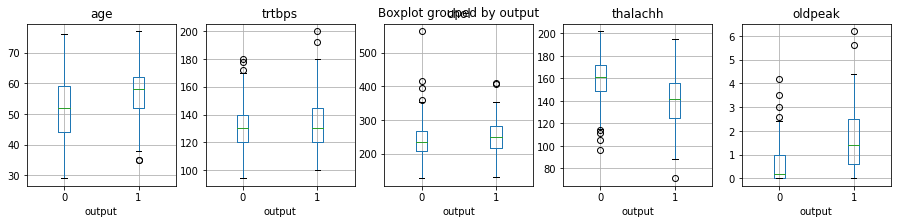

In [17]:
fig, ax = plt.subplots(1,5, figsize=(15,3))

for i, col in enumerate(cols):
    df.boxplot(column=col, by='output', ax=ax[i])

We can see that the difference is very pronounced for `thalachh` and `oldpeak`, which is not surprising since these have correlations in the range of ~0.4. On the other hand, `trtbps` with a correlation of 0.14 has very similar looking boxplots for the two output values. 

### Plans for model

To perform the classification process, we will be using two models- the logistic regression model and the K-Nearest Neighbors model. These are two very different methods of performing classification, but we can compare the two methods by computing their prediction rate.

Two factors have to be kept in mind when considering these models:
1) Logistic Regression is a parametric model while KNN is non-parametric. This means logistic regression will tell me exactly how much each feature contributes to the prediction of the output, and the confidence with which I can make these claims, whereas KNN will only tell me the prediction values computed from the conditional probabilities.

2) KNN does not accept unordered categorical features (of which I have many) whereas logistic regression does. This will inevitably have an effect on the quality of prediction produces by the two models, and I expect the logistic regression model to perform better since it can take advantage of more of the dataset to make predictions.

### Investigating the multicollinearity



Before modelling the data, we should check the multicollinearity of the feature variables. Multicollinearity occurs when one predictor correlates with the others- that is we essentially have extra variables that encode the same information within the model. Removing multicollinear predictors is important to have a more interpretable model and to ensure that correlated features don't carry extra weight in the model than desired. 

We will use the variance inflation factor (VIF) metric to assess multicollinearity. VIF takes on values greater than or equal to one- a variable with large VIF value has large multicollinearity with the other variables in the data. We will proceed by removing columns with VIF greater than 5. First, we check the VIF of the data right now.

In [118]:
# Extract predictor variables
X = df[list(df.columns[:-1])]

# Create empty dataframe to display VIF
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)


,VIF,Column
3,58.557335,trtbps
7,42.742178,thalachh
0,38.998305,age
4,26.267365,chol
12,17.165303,thall
10,10.072734,slp
1,3.523211,sex
9,3.062890,oldpeak
2,2.414403,cp
6,2.058206,restecg


As we can see, six columns here have VIFs much larger than five, meaning they are highly correlated with the others. By dropping the largest five of these, we can arrive with a dataset where all the columns have have VIF less than 5.

In [119]:
X = X.drop(['trtbps', 'thalachh', 'age', 'chol', 'thall'], axis=1)

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)


,VIF,Column
6,3.756703,slp
0,3.038525,sex
1,2.112149,cp
5,2.062440,oldpeak
3,1.957971,restecg
4,1.795800,exng
7,1.686170,caa
2,1.222870,fbs


Now all the remaining variables have VIF less than 5, which indicates sufficiently low multicollinearity.

### Regularization of data

In order to use the `sklearn` library we will have to convert the dataframe to two numpy arrays for the X and y values respectively, where X represents the predictors and y the response `output` column.

In [120]:
X = X.values
y = df.output

KNN is a model that uses distance between points to make predictions- points that are closer together are assumed to belong to a similar category. However, it is difficult to weigh these distances for different predictors since they have different ranges of values.

To standardize these features, we can use sklearn's `scale` function and scale the various features. This transforms the data so that they have the same distribution as before, but their mean is now centered at 0 and variance is 1.

In [121]:
scale_X = sklearn.preprocessing.scale(X, axis=0)

We can plot the X values before and after scaling to see the effect of scaling. As noted, the mean for the scaled features is centered at 0 and the variance is 1. 

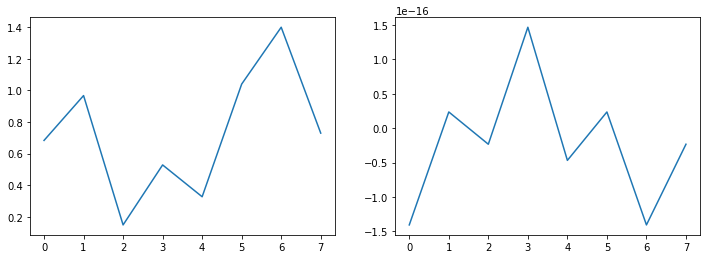

In [122]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(np.mean(X, axis=0))
ax[1].plot(np.mean(scale_X, axis=0));

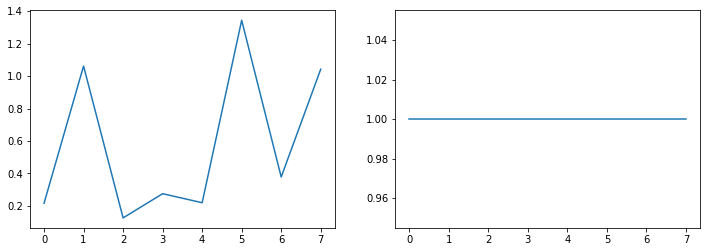

In [123]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(np.var(X, axis=0))
ax[1].plot(np.var(scale_X, axis=0));

Now that the data is scaled, we can proceed to split the data into training and test sets by using sklearn's `train_test_split` function. Since the number of samples is low (303) I will dedicate more of the data to the training sample (70%) in order to create a better classifier.

In [133]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(scale_X, y, test_size=0.3)
print("Length of training:", len(y_train), "length of test:", len(y_test))

Length of training: 212 length of test: 91


### Model 1: K-Nearest Neighbors

#### Hyperparameter tuning to find the optimal number of neighbors

First we will iterate over the number of neighbors from 1 to 20 and find the test score of each, in order to pick the one with the greatest score. We use test data to ensure that we are not overfitting the model to the training data. 

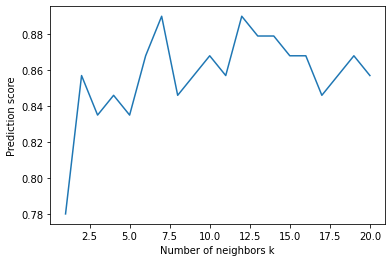

In [150]:
scores = []
ks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for k in ks:
    knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors= k)
    knn_model.fit(X_train, y_train)
    k_score = knn_model.score(X_test, y_test)
    scores.append(k_score)
plt.plot(ks, scores)
plt.xlabel("Number of neighbors k")
plt.ylabel("Prediction score");

In [151]:
print("The highest score is for the model with k =", ks[np.argmax(scores)], "with a score of", np.max(scores))

The highest score is for the model with k = 7 with a score of 0.8901098901098901


#### Analyzing model through Confusion Matrix, Recall Rate, ROC, AUC

Now that we can know the number of neighbors that yields the highest score, we can further analyze the model produced. First we study the confusion matrix.

In [136]:
knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors= 7)
knn_model.fit(X_train, y_train)
knn_hat = knn_model.predict(X_test)
knn_cm = sklearn.metrics.confusion_matrix(y_test, knn_hat)
print("Confusion matrix:\n", knn_cm)
print("True negatives:", knn_cm[0,0])
print("True positives:", knn_cm[1,1])
print("False negatives:", knn_cm[1,0])
print("False positives:", knn_cm[0,1])

Confusion matrix:
 [[50  8]
 [ 2 31]]
True negatives: 50
True positives: 31
False negatives: 2
False positives: 8


In [137]:
print("Recall is:", knn_cm[1,1]/(knn_cm[1,0]+knn_cm[1,1]))

Recall is: 0.9393939393939394


In [138]:
print(sklearn.metrics.classification_report(y_test, knn_hat))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91        58
           1       0.79      0.94      0.86        33

    accuracy                           0.89        91
   macro avg       0.88      0.90      0.89        91
weighted avg       0.90      0.89      0.89        91



Finally, we display the ROC curve to visually inspect the effectiveness of this model. The ROC measures the false positive rate versus the true positive rate at different classification thresholds. The are under the ROC curve (AUC), is another metric we can use to assess the effectiveness of the model. To compute the ROC curve for KNN we have to extract the probabilities of each prediction.

In [139]:
y_scores = knn_model.predict_proba(X_test)
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, y_scores[:, 1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
print("AUC:", roc_auc)

AUC: 0.918234064785789


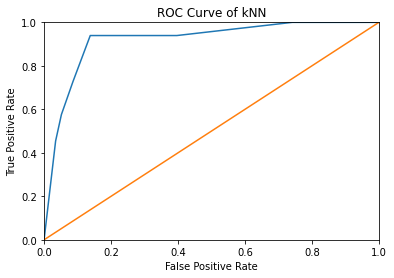

In [140]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN');

We see that the Area Under the Curve for this KNN model is 0.90, which is pretty good. This can be seen by the ROC curve that is hugging the top left corner of the graph, which shows that this model can achieve high true positive rates for relatively low false positive rates.

### Model 2: Logistic Regression

The second model we will use is logistic regression. We use the same training and test samples as before, so we can directly compare the prediction scores, recall, ROC curve and AUC for both models.

In [141]:
lr = sklearn.linear_model.LogisticRegression()
lr_model = lr.fit(X_train, y_train)
lr_hat = lr_model.predict(X_test)
print("Logistic regression score:", lr_model.score(X_test, y_test))

Logistic regression score: 0.8681318681318682


In [142]:
lr_cm = sklearn.metrics.confusion_matrix(y_test, lr_hat)
print('Logistic confusion matrix is = \n', lr_cm)
print("True negatives:", lr_cm[0,0])
print("True positives:", lr_cm[1,1])
print("False negatives:", lr_cm[1,0])
print("False positives:", lr_cm[0,1])

Logistic confusion matrix is = 
 [[49  9]
 [ 3 30]]
True negatives: 49
True positives: 30
False negatives: 3
False positives: 9


In [143]:
print("Recall is:", lr_cm[1,1]/(lr_cm[1,0]+lr_cm[1,1]))

Recall is: 0.9090909090909091


In [144]:
print(sklearn.metrics.classification_report(y_test, lr_hat))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89        58
           1       0.77      0.91      0.83        33

    accuracy                           0.87        91
   macro avg       0.86      0.88      0.86        91
weighted avg       0.88      0.87      0.87        91



In [145]:
y_scores = lr_model.predict_proba(X_test)
# fpr is false positive rate, tpr is true positive rate
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, y_scores[:, 1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
print("AUC:", roc_auc)

AUC: 0.9425287356321839


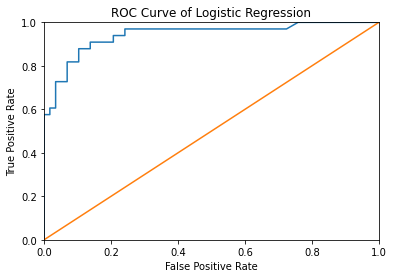

In [146]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression');

### Comparing the results

As mentioned earlier, this is a class-balanced data set (about 45% of samples have output = 1) so we can use the accuracy score as a reliable metric to evaluate the models.

The accuracy of the KNN model for 7 neighbors is 0.89, whereas the score for logistic regression is 0.87.

The recall score for KNN is 0.94, whereas the score for logistic regression is 0.91.

The F1 score for KNN is 0.86, whereas the F1 score for logistic regression is 0.83

Finally, the AUC for KNN is 0.92 whereas the AUC for logistic regression is 0.94.

The first thing to note is that the difference between scores is fairly marginal- KNN and logistic regression are within 0.03 of each other for every metric we have measured.

Between them, we see that KNN outperforms logistic regression when considering the accuracy, the recall score, and the F1 score whereas logistic regression slightly outperforms KNN for AUC.

#### Considering the AUC

What does it mean for logistic regression to outperform KNN in AUC, despite performing worse in accuracy? The AUC metric utilizes probabilities of predictions, as opposed to accuracy that just looks at binary 'yes/no' for the `output` variable. This means that the logistic regression model is more confident of its correct predictions than the KNN model. Thus, while the accuracy is greater for KNN in this test data set, the logistic regression model is more likely to have higher accuracy for future samples. As such, even though the difference is marginal, I would pick logistic regression over KNN for future datasets. 

### Conclusion

The KNN model with 7 neighbors and the Logistic Regression model both are both effective at predicting the likelihood of having a heart attack given the medical data provided, with a prediction accuracy of 0.89 and 0.87 respectively and an AUC of 0.92 and 0.94 respectively. Since logistic regression has a marginally higher AUC, I believe it makes for a slightly better model for this study.

### Problems and Scope for improvement

The biggest problem I faced in this project is the small sample size. This is something that I only grew to appreciate in the third part of the project, when I actually started building the model. Having only 303 data points meant that the test set ended up with 91 points, which was small enough to cause considerable variation every time I tried a different test/train split. This made the results and conclusions gathered to be rather volatile; with a different split I may have ended with a markedly different conclusion. Moreover, as I worked on the project I realized that I wanted to add a further split in the data to perform cross-validation. But because the training and test set were too small as is, I had to give up on this.

Another difficulty I faced in this project is not having the domain knowledge necessary to evaluate different performance metrics. One such instance is- when considering heart attacks, is precision or recall a more important metric to consider? And what is the cost of a false positive? For example- if were working to predict malignant tumors, then I know that the cost of a false positive is having a healthy person suffer through chemotherapy, which is a terrible ordeal. As such, maximizing precision is an important part of classifying malignant tumors because we want to minimize the number of false positives produced by the model.

But what about the case of heart attacks? If the cost of a false positive is not as high then we could afford to sacrifice precision for an increase in recall. Indeed, in both the KNN and logistic regression model we see precision in the range of 0.77 to 0.79 whereas the recall is in the range of 0.91 to 0.94. However, if the cost of a false positive is just as high in the case of heart attacks, then I would alter classification threshold in order to increase the precision of the model. Making such a decision requires domain knowledge that I do not possess, but someone with more understanding of this situation could modify the models accordingly.